# Hello! In this notebook, we will find the stellar inclination of an HWO target.

We start by querying our data from exoplanet archive

In [1]:
from tap_query import *

In [2]:
# load our hwo data
df = pd.read_csv('hwo_exp.csv', sep=',', skiprows=60, header=1)

#query nasa exp archive
base_url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query="
query = {
    "select"   : """pl_name, hd_name, pl_refname, gaia_dr3_id, 
                    st_teff, st_rad, st_raderr1, st_raderr2,
                    st_vsin, st_vsinerr1, st_vsinerr2,
                    st_rotp, st_rotperr1, st_rotperr2""",
    "from"     : "ps"
}
ps_df = tap_query(base_url, query)

# pull out data for hwo targets
hwo_from_ps_mask = ps_df['hd_name'].isin(df['hd_name'])
hwo_from_ps = ps_df[hwo_from_ps_mask]

print(f"number of unique entries matched: {hwo_from_ps['hd_name'].nunique()}")

https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,+hd_name,+pl_refname,+gaia_dr3_id,+
++++++++++++++++++++st_teff,+st_rad,+st_raderr1,+st_raderr2,
++++++++++++++++++++st_vsin,+st_vsinerr1,+st_vsinerr2,
++++++++++++++++++++st_rotp,+st_rotperr1,+st_rotperr2+from+ps&format=csv
number of unique entries matched: 25


In [3]:
# Here we focus on only the indices where st_rotp and st_rotperr are missing
# these are the easiest to get ourselves

rotp_nan_idx, other_nan_idx = find_nan_indices(hwo_from_ps)
print("Indices with only st_rotp and st_rotperr1 NaN:", rotp_nan_idx)

Indices with only st_rotp and st_rotperr1 NaN: [42, 46, 52, 55, 70, 81, 82, 83, 85, 86, 100, 108, 109, 110, 117, 124, 130, 136, 137, 138, 141, 143, 150, 151, 157, 160, 161]


In [4]:
# lets look at the first index for now
print(hwo_from_ps.iloc[rotp_nan_idx[0]])

pl_name                                              HD 160691 b
hd_name                                                HD 160691
pl_refname     <a refstr=BENEDICT_ET_AL__2022 href=https://ui...
gaia_dr3_id                         Gaia DR3 5945941905576552064
st_teff                                                   5773.0
st_rad                                                      1.33
st_raderr1                                                  0.02
st_raderr2                                                 -0.02
st_vsin                                                      3.1
st_vsinerr1                                                  0.5
st_vsinerr2                                                 -0.5
st_rotp                                                      NaN
st_rotperr1                                                  NaN
st_rotperr2                                                  NaN
Name: 2182, dtype: object


To get stellar rotation periods, we use SpinSpotter

In [5]:
from spinspotter import *

/home/ktp9/.conda/envs/stinc312/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [6]:
test = ss_tutorial('HD 160691', plot=False) #switch to plot=True to assess the best period yourself
test_data = np.array(test[1:])  # skip header if needed

# Mask rows where the first column is not NaN
nanmask = ~np.isnan(test_data[:, 0])
print(f"data {test_data}")

Beginning period analysis of HD 160691
using collection 1 of 10
using collection 2 of 10
using collection 3 of 10
using collection 4 of 10
using collection 5 of 10
using collection 6 of 10


/home/ktp9/.conda/envs/stinc312/lib/python3.12/site-packages/SpinSpotter/function_library.py:562: RuntimeWarning: Mean of empty slice
  results['A_avg'] = np.nanmean(results['A_k'])
/home/ktp9/.conda/envs/stinc312/lib/python3.12/site-packages/SpinSpotter/function_library.py:563: RuntimeWarning: Mean of empty slice
  results['B_avg'] = np.nanmean(results['B_k'])
/home/ktp9/.conda/envs/stinc312/lib/python3.12/site-packages/SpinSpotter/function_library.py:564: RuntimeWarning: Mean of empty slice
  results['R_avg'] = np.nanmean(results['Rsq_k'])
/home/ktp9/.conda/envs/stinc312/lib/python3.12/site-packages/SpinSpotter/function_library.py:570: RuntimeWarning: Mean of empty slice
  results['P_err'] = np.nanmean(results['hwhm_k'])
/home/ktp9/.conda/envs/stinc312/lib/python3.12/site-packages/SpinSpotter/function_library.py:562: RuntimeWarning: Mean of empty slice
  results['A_avg'] = np.nanmean(results['A_k'])
/home/ktp9/.conda/envs/stinc312/lib/python3.12/site-packages/SpinSpotter/function_lib

using collection 7 of 10
using collection 8 of 10
using collection 9 of 10
using collection 10 of 10
data [[6.28967171 8.19429473 2.59798605 4.94454822        nan        nan
         nan        nan        nan        nan]
 [0.20659629 3.75070431 0.07512739 0.1832321  1.04738336        nan
         nan        nan 2.3444287  1.91078257]]


In [7]:
# Lets stick with the first found period for now
period = test_data[:, 0]

Now, it's time to sample for cos i

In [8]:
from bayesian_i import *

In [9]:
P, P_err = period[0], period[1]
R, R_err = hwo_from_ps['st_rad'].iloc[rotp_nan_idx[0]], hwo_from_ps['st_raderr1'].iloc[rotp_nan_idx[0]]

v_obs, v_sigma = get_velocity(R, P), get_sig_velocity(R, P, R_err, P_err)
u_obs, u_sigma = hwo_from_ps['st_vsin'].iloc[rotp_nan_idx[0]], hwo_from_ps['st_vsinerr1'].iloc[rotp_nan_idx[0]]

most probable cos i = 0.45814070351758795
most probable i = 62.73280457107509 degrees


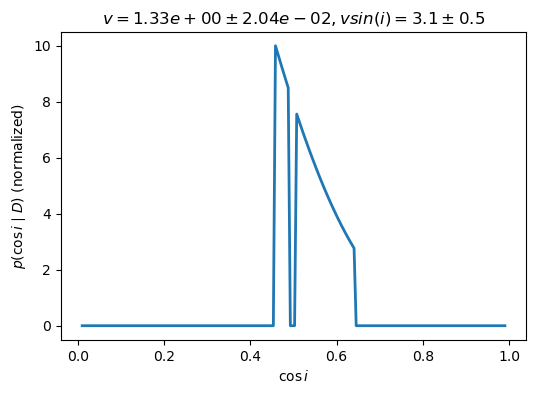

In [10]:
# --- Evaluate over a grid of cos(i) ---
cosi_grid = np.linspace(0.01, 0.99, 200)
posterior = np.array([p_cosi(c, v_obs, u_obs, v_sigma, u_sigma) for c in cosi_grid])
posterior /= np.trapezoid(posterior, cosi_grid)  # normalize

print(f"most probable cos i = {cosi_grid[np.argmax(posterior)]}")
print(f"most probable i = {np.degrees(np.arccos(cosi_grid[np.argmax(posterior)]))} degrees")

# --- Plot ---
plt.figure(figsize=(6,4))
plt.plot(cosi_grid, posterior, lw=2)
plt.xlabel(r'$\cos i$')
plt.ylabel(r'$p(\cos i \mid D)$ (normalized)')
plt.title(fr'$v = {v_obs:.2e} \pm {v_sigma:.2e}, v sin(i) = {u_obs} \pm {u_sigma}$')
plt.show()